In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Paths
train_csv = r'/content/drive/My Drive/Dataset/Final_dataset_3/metadata/metadata_train.csv'  # Train spreadsheet
test_csv = r'/content/drive/My Drive/Dataset/Final_dataset_3/metadata/metadata_test.csv'    # Test spreadsheet
train_audio_dir = r'/content/drive/My Drive/Dataset/Final_dataset_3/Audio/Train_audio'  # Directory for training audio files
test_audio_dir = r'/content/drive/My Drive/Dataset/Final_dataset_3/Audio/Test_audio'    # Directory for testing audio

In [ ]:
# Parameters
sr = 22050  # Sampling rate
n_mels = 128  # Number of Mel bands
img_size = (128, 128)  # Size of the spectrogram image

In [ ]:
import pickle

def load_from_drive(filename):
    load_path = f'/content/drive/My Drive/{filename}'
    with open(load_path, 'rb') as f:
        return pickle.load(f)

X_train, y_train = load_from_drive('X_train_y_train.pkl')
X_val, y_val = load_from_drive('X_val_y_val.pkl')
X_test, y_test = load_from_drive('X_test_y_test.pkl')

In [ ]:
print("Starting X_train shape:", X_train.shape)
print("Starting X_val shape:", X_val.shape)
print("Starting X_test shape:", X_test.shape)

Starting X_train shape: (5154, 128, 128)
Starting X_val shape: (1289, 128, 128)
Starting X_test shape: (1614, 128, 128)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


X_train = np.squeeze(X_train)
X_val = np.squeeze(X_val)
X_test = np.squeeze(X_test)
#✅ Expand Only Once (Ensuring shape = (num_samples, 128, 128, 1))
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# ✅ Verify Shape
print("Fixed X_train shape:", X_train.shape)
print("Fixed X_val shape:", X_val.shape)
print("Fixed X_test shape:", X_test.shape)

# ✅ Define Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# ✅ Fit Data Augmentation on Training Data
datagen.fit(X_train)

# ✅ Define Model Architecture
def build_improved_model(input_shape):
    model = Sequential([
        Conv2D(32, (5, 5), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        AveragePooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),


        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),


        Dense(4, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# ✅ Define Model Input Shape
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_improved_model(input_shape)
print(model.summary())

# ✅ Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

# ✅ Train the Model Using Augmented Data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)

Fixed X_train shape: (5154, 128, 128, 1)
Fixed X_val shape: (1289, 128, 128, 1)
Fixed X_test shape: (1614, 128, 128, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,750,596 (10.49 MB)

 Trainable params: 2,749,764 (10.49 MB)

 Non-trainable params: 832 (3.25 KB)

None
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.5634 - loss: 2.4902 - val_accuracy: 0.5927 - val_loss: 2.0519 - learning_rate: 5.0000e-04
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7575 - loss: 1.3992 - val_accuracy: 0.7153 - val_loss: 1.4553 - learning_rate: 5.0000e-04
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7730 - loss: 1.3008 - val_accuracy: 0.6214 - val_loss: 1.8488 - learning_rate: 5.0000e-04
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8046 - loss: 1.1727 - val_accuracy: 0.6369 - val_loss: 1.6807 - learning_rate: 5.0000e-04
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8184 - loss: 1.0550 - val_accuracy: 0.8169 - val_loss: 1.0603 - learning_rate: 2.5000e-04
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8546 - loss: 0.9488 - val_accuracy: 0.8689 - val_loss: 0.9063 - learning_rate: 2.5000e-04
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8

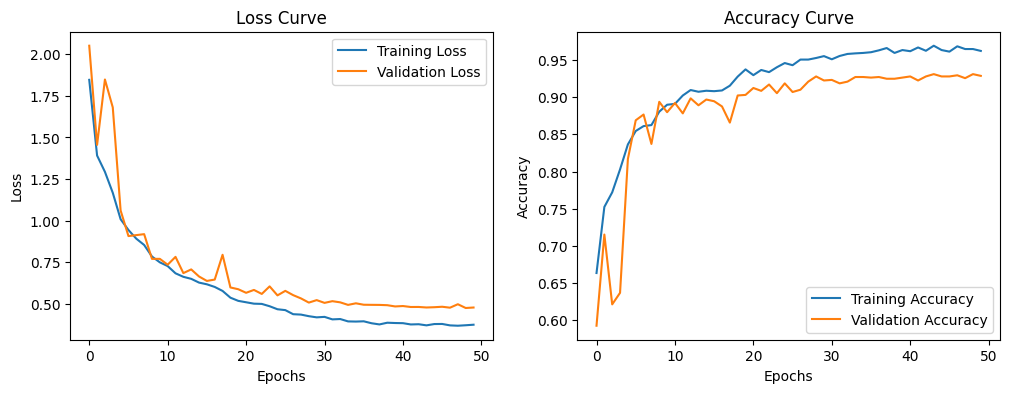

In [ ]:
# ✅ Plot Training Curves (Optional, but useful)
import matplotlib.pyplot as plt

def plot_training(history):
    plt.figure(figsize=(12, 4))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.show()

# ✅ Call this after training
plot_training(history)

In [ ]:
# Evaluate the model
print("Evaluating the model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Evaluating the model...
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9328 - loss: 0.4595
Test Accuracy: 0.92


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions (returns probabilities for each class)
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels (choose the class with highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report for 3 classes
print(classification_report(y_test, y_pred, target_names=['Others', 'Car horn', 'Scream','Dog bark']))


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

      Others       0.83      0.91      0.87       413
    Car horn       0.97      0.93      0.95       399
      Scream       0.95      0.96      0.95       401
    Dog bark       0.95      0.89      0.92       401

    accuracy                           0.92      1614
   macro avg       0.92      0.92      0.92      1614
weighted avg       0.92      0.92      0.92      1614



In [ ]:
# import tensorflow as tf


# # Define the path in Google Drive
# model_path = "/content/drive/My Drive/models/my_model1.keras"

# # Save the model (Keras automatically infers the format)
# model.save(model_path)


In [ ]:
# from tensorflow.keras.models import load_model

# def predict_audio(file_path, model):
#     """
#     Predict the class of an audio file and return the corresponding label.
#     - file_path: Path to the audio file.
#     - model: Trained model for prediction.
#     """
#     input_data = preprocess_audio(file_path)  # Ensure this outputs the correct spectrogram format
#     input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

#     prediction = model.predict(input_data)
#     predicted_label = np.argmax(prediction, axis=1)[0]  # Get class index

#     # Map class index to labels
#     label_map = {0: "Other", 1: "Car Horn", 2: "Scream", 3:"Bark"}

#     return label_map.get(predicted_label, "Unknown")

# def predict_folder(src_folder, model):
#     """
#     Predict all audio files in a folder and print the results.
#     - src_folder: Folder containing audio files to predict.
#     - model: Trained model for prediction.
#     """
#     audio_files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]

#     for file_name in audio_files:
#         file_path = os.path.join(src_folder, file_name)
#         try:
#             result = predict_audio(file_path, model)
#             print(f"Prediction for '{file_name}': {result}")
#         except Exception as e:
#             print(f"Error predicting '{file_name}': {e}")

# if __name__ == "__main__":
#     source_dir = r'/content/drive/My Drive/Dataset/Prediction/Not car audio trimmed'

#     # Assume a trained model is loaded here
#     model = load_model("horn_scream_noise_model3.keras")

#     # Predict all audio files in the folder
#     predict_folder(src_folder=source_dir, model=model)


In [ ]:
# if __name__ == "__main__":
#     source_dir = r'/content/drive/My Drive/Dataset/Prediction/car_horn_trimmed'

#     # Assume a trained model is loaded here
#     model = load_model("horn_scream_noise_model3.keras")

#     # Predict all audio files in the folder
#     predict_folder(src_folder=source_dir, model=model)

In [ ]:

# source_dir = r'/content/drive/My Drive/Dataset/Prediction/scream'

# # Assume a trained model is loaded here
# model = load_model("horn_scream_noise_model3.keras")

# # Predict all audio files in the folder
# predict_folder(src_folder=source_dir, model=model)